# Model selection and hiperparamiters optimalisation

Zuzanna Gorczyca, zgo@kth.se

Alga Nour Elimane, nealga@kth.se

Tse An Shih, tashih@kth.se

### Imports

In [70]:
#SYSTEM STAFF
import numpy as np
import pandas as pd
import os
import sys
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#SKLEARN TOOLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.metrics import precision_score

import matplotlib.pyplot as plt
from scipy.stats import f_oneway

## Data loading

In [18]:
print(sys.executable)

s:\KTH\Programing_for_data_science\.venv\Scripts\python.exe


In [20]:
dir_path = os.getcwd()
dir_path

's:\\KTH\\Programing_for_data_science\\Assignment4'

In [21]:
smoth_path = os.path.join(dir_path, "datasets", "training_smiles_processed_smoth.csv")
adysyn_path = os.path.join(dir_path, "datasets", "training_smiles_processed_adysyn.csv")
inbalance_path = os.path.join(dir_path, "datasets", "training_smiles_processed_norm_bins.csv")

In [22]:
smoth_data = pd.read_csv(smoth_path, index_col = 'INDEX')
smoth_data.head()

ValueError: Index INDEX invalid

In [ ]:
adysyn_data = pd.read_csv(adysyn_path, index_col = 'INDEX')
adysyn_data.head()

,ACTIVE,NoAtoms,CalcExactMolWt,HeavyAtomCount,NumHDonors,NumHAcceptors,MFp_0,MFp_1,MFp_2,MFp_3,...,MFp_114,MFp_115,MFp_116,MFp_117,MFp_118,MFp_119,MFp_120,MFp_121,MFp_122,MFp_123
INDEX,,,,,,,,,,,,,,,,,,,,,
0,0.0,9,9,9,1,2,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
1,0.0,1,2,1,0,1,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
2,0.0,9,9,9,0,3,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,0.0,8,8,8,1,2,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,2,2,2,1,3,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [ ]:
inbalance_data = pd.read_csv(inbalance_path, index_col = 'INDEX')
inbalance_data.head()

,NoAtoms,CalcExactMolWt,HeavyAtomCount,NumHDonors,NumHAcceptors,MFp_0,MFp_1,MFp_2,MFp_3,MFp_4,...,MFp_115,MFp_116,MFp_117,MFp_118,MFp_119,MFp_120,MFp_121,MFp_122,MFp_123,ACTIVE
INDEX,,,,,,,,,,,,,,,,,,,,,
1,9,9,9,1,2,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
2,1,2,1,0,1,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
3,9,9,9,0,3,0.0,0.0,1.0,1.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,8,8,8,1,2,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,2,2,2,1,3,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


## Chosen Classifiers

In this project we using 4 different classifiers:
- Random Forest
- Decision Tree
- Multi-Layer Perceptron
- Naive Bayes

In [23]:
Classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(50,),     
        activation='relu',
        alpha=0.0001,
        learning_rate_init=0.001,
        max_iter=200,                 
        early_stopping=True,          # stops automatically when no improvement
        n_iter_no_change=5,
        random_state=42
    ),
    "Naive Bayes": GaussianNB()
}

## Test different datasets: 

### Inbalance data

In [24]:
X_inbalance = inbalance_data.drop("ACTIVE", axis=1)  # features
y_inbalance = inbalance_data["ACTIVE"]               # label 

#splitting data 
X_train_inb, X_val_inb, y_train_inb, y_val_inb = train_test_split(
    X_inbalance, y_inbalance, test_size=0.2, random_state=42, stratify=y_inbalance)

In [25]:
#Training + computing AUC 

auc_scores_inb = {}

for name, clf in Classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train_inb, y_train_inb)
    y_prob = clf.predict_proba(X_val_inb)[:, 1]
    auc = roc_auc_score(y_val_inb, y_prob)
    auc_scores_inb[name] = auc
    print(f"{name} AUC: {auc:.4f}\n")


# Selecting our best classifier 

best_clf_name = max(auc_scores_inb, key=auc_scores_inb.get)
print(f"Best classifier: {best_clf_name} with AUC = {auc_scores_inb[best_clf_name]:.4f}")
best_clf = Classifiers[best_clf_name]


Training Random Forest...
Random Forest AUC: 0.4995

Training Decision Tree...
Decision Tree AUC: 0.4952

Training MLP...
MLP AUC: 0.4992

Training Naive Bayes...
Naive Bayes AUC: 0.4998

Best classifier: Naive Bayes with AUC = 0.4998


Before assuming that MLP is the best model and since there is no much gap in auc score it's important to try to switch parameters and see if one of these models can top it 

### SMOTH data

In [26]:
X_smoth = smoth_data.drop("ACTIVE", axis=1)  # features
y_smoth = smoth_data["ACTIVE"]               # label 

#splitting data 
X_train_smoth, X_val_smoth, y_train_smoth, y_val_smoth = train_test_split(
    X_smoth, y_smoth, test_size=0.2, random_state=42, stratify=y_smoth)

In [27]:
auc_scores_smoth = {}

for name, clf in Classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train_smoth, y_train_smoth)
    y_prob = clf.predict_proba(X_val_smoth)[:, 1]
    auc = roc_auc_score(y_val_smoth, y_prob)
    auc_scores_smoth[name] = auc
    print(f"{name} AUC: {auc:.4f}\n")


# Selecting our best classifier 

best_clf_name = max(auc_scores_smoth, key=auc_scores_smoth.get)
print(f"Best classifier: {best_clf_name} with AUC = {auc_scores_smoth[best_clf_name]:.4f}")
best_clf = Classifiers[best_clf_name]


Training Random Forest...
Random Forest AUC: 0.9871

Training Decision Tree...
Decision Tree AUC: 0.9258

Training MLP...
MLP AUC: 0.8769

Training Naive Bayes...
Naive Bayes AUC: 0.7659

Best classifier: Random Forest with AUC = 0.9871


### ADYSYN data

In [28]:
X_adysyn = adysyn_data.drop("ACTIVE", axis=1)  # features
y_adysyn = adysyn_data["ACTIVE"]               # label 

#splitting data 
X_train_adysyn, X_val_adysyn, y_train_adysyn, y_val_adysyn = train_test_split(
    X_adysyn, y_adysyn, test_size=0.2, random_state=42, stratify=y_adysyn)

In [29]:
auc_scores_adysyn = {}

for name, clf in Classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train_adysyn, y_train_adysyn)
    y_prob = clf.predict_proba(X_val_adysyn)[:, 1]
    auc = roc_auc_score(y_val_adysyn, y_prob)
    auc_scores_adysyn[name] = auc
    print(f"{name} AUC: {auc:.4f}\n")


# Selecting our best classifier 

best_clf_name = max(auc_scores_adysyn, key=auc_scores_adysyn.get)
print(f"Best classifier: {best_clf_name} with AUC = {auc_scores_adysyn[best_clf_name]:.4f}")
best_clf = Classifiers[best_clf_name]


Training Random Forest...
Random Forest AUC: 0.9872

Training Decision Tree...
Decision Tree AUC: 0.9278

Training MLP...
MLP AUC: 0.8890

Training Naive Bayes...
Naive Bayes AUC: 0.7693

Best classifier: Random Forest with AUC = 0.9872


For inbalance data AUC ROC score is lower then 0.5 so we can consider that our results are worst then random classification. 

For data oversmapled by SMOTH method we get best AUC score for Random Forest algotithm and the second best is Decision Tree
ication. 

For data oversmapled by ADYSYN method we get best AUC score for Random Forest algotithm and the second best is Decision Tree 

## Model Selection + Hyperparameters Tuning on balanced Data 

We will optimalise hyperparamiters for SMOTH and ADYSYN datasets form Fandom Forest and Decision Tree algotithms.


### SMOTH dataset

#### Random Forest

In [31]:
# Random Forest 

print("Starting Random Forest tuning...")
rf_params = {
    "n_estimators": [50, 55, 100, 150, 200, 250]
}

rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(rf, rf_params, n_iter=4, cv=3, scoring="roc_auc", n_jobs=1, random_state=42, verbose=2)
rf_random.fit(X_smoth, y_smoth)
print("Best RF params:", rf_random.best_params_)
print("Best RF AUC:", rf_random.best_score_)


Starting Random Forest tuning...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ....................................n_estimators=50; total time=  43.1s
[CV] END ....................................n_estimators=50; total time=  42.9s
[CV] END ....................................n_estimators=50; total time=  43.1s
[CV] END ....................................n_estimators=55; total time=  45.1s
[CV] END ....................................n_estimators=55; total time=  47.1s
[CV] END ....................................n_estimators=55; total time=  47.3s
[CV] END ...................................n_estimators=250; total time= 3.4min
[CV] END ...................................n_estimators=250; total time= 3.6min
[CV] END ...................................n_estimators=250; total time= 3.6min
[CV] END ...................................n_estimators=100; total time= 1.4min
[CV] END ...................................n_estimators=100; total time= 1.4min
[CV] END .......

#### Decision Tree

In [32]:
print("\nStarting Decision Tree tuning...")
dt_params = {
    "max_depth": [None, 5, 10, 15, 20, 25]
}

dt = DecisionTreeClassifier(random_state=42)
dt_random = RandomizedSearchCV(dt, dt_params, n_iter=4, cv=3, scoring="roc_auc", n_jobs=-1, random_state=42, verbose=2)
dt_random.fit(X_smoth, y_smoth)
print("Best DT params:", dt_random.best_params_)
print("Best DT AUC:", dt_random.best_score_)


Starting Decision Tree tuning...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best DT params: {'max_depth': 25}
Best DT AUC: 0.9350204558750005


### mAyby later

In [ ]:
print("\nStarting MLP tuning...")
mlp_params = {
    "hidden_layer_sizes": [(50,), (100,), (100,50)],
    "activation": ["relu", "tanh"],
    "alpha": [0.0001, 0.001],
    "learning_rate_init": [0.001, 0.01]
}

mlp = MLPClassifier(max_iter=300, random_state=42)
mlp_random = RandomizedSearchCV(
    mlp, mlp_params, n_iter=10, cv=3, scoring="roc_auc", n_jobs=-1,
    random_state=42, verbose=2
)
mlp_random.fit(X_train, y_train)
print("Best MLP params:", mlp_random.best_params_)
print("Best MLP AUC:", mlp_random.best_score_)


In [ ]:
print("\nNaive bayes  ")
nb = GaussianNB()
nb.fit(X_train, y_train)
y_prob = nb.predict_proba(X_val)[:, 1]
print("Naive Bayes AUC:", roc_auc_score(y_val, y_prob))

### ADYSYN dataset

#### Random Forest

In [34]:
print("Starting Random Forest tuning...")
rf_params = {
    "n_estimators": [50, 55, 100, 150, 200, 250]
}

rf = RandomForestClassifier(random_state=42)
rf_random = RandomizedSearchCV(rf, rf_params, n_iter=4, cv=3, scoring="roc_auc", n_jobs=1, random_state=42, verbose=2)
rf_random.fit(X_adysyn, y_adysyn)
print("Best RF params:", rf_random.best_params_)
print("Best RF AUC:", rf_random.best_score_)


Starting Random Forest tuning...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ....................................n_estimators=50; total time=  39.4s
[CV] END ....................................n_estimators=50; total time=  39.8s
[CV] END ....................................n_estimators=50; total time=  40.0s
[CV] END ....................................n_estimators=55; total time=  42.6s
[CV] END ....................................n_estimators=55; total time=  44.6s
[CV] END ....................................n_estimators=55; total time=  45.9s
[CV] END ...................................n_estimators=250; total time= 3.2min
[CV] END ...................................n_estimators=250; total time= 3.4min
[CV] END ...................................n_estimators=250; total time= 3.4min
[CV] END ...................................n_estimators=100; total time= 1.3min
[CV] END ...................................n_estimators=100; total time= 1.3min
[CV] END .......

#### Decision Tree

In [35]:
print("\nStarting Decision Tree tuning...")
dt_params = {
    "max_depth": [None, 5, 10, 15, 20, 25]
}
dt = DecisionTreeClassifier(random_state=42)
dt_random = RandomizedSearchCV(dt, dt_params, n_iter=4, cv=3, scoring="roc_auc", n_jobs=-1, random_state=42, verbose=2)
dt_random.fit(X_adysyn, y_adysyn)
print("Best DT params:", dt_random.best_params_)
print("Best DT AUC:", dt_random.best_score_)


Starting Decision Tree tuning...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best DT params: {'max_depth': 25}
Best DT AUC: 0.9303150394346128


## Final cross validation of our best models

Best models:
* Random Forest
* Decision Tree

Best datasets:
* SMOTH
* ADYSYN


### SMOTH dataset

#### Random Forest

In [ ]:
print("FINAL CROSS-VALIDATION WITH RANDOM FOREST")
RF_smoth = RandomForestClassifier(n_estimators=250, random_state=42)

#  10-fold cross-validation on the FULL training set
cv_scores_RF_smoth = cross_validate(
    RF_smoth,
    X_smoth,  # Full training set 
    y_smoth,
    cv=10,  # 10-fold cross-validation
    scoring={
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc',
        'precision': make_scorer(precision_score, zero_division=0)
    },
)

# Display cross-validation results
print(f"\nCross-Validation Results (10-fold):")
print(f"  Accuracy:  {cv_scores_RF_smoth['test_accuracy'].mean():.4f} (+/- {cv_scores_RF_smoth['test_accuracy'].std():.4f})")
print(f"  ROC-AUC:   {cv_scores_RF_smoth['test_roc_auc'].mean():.4f} (+/- {cv_scores_RF_smoth['test_roc_auc'].std():.4f})")
print(f"  Precision: {cv_scores_RF_smoth['test_precision'].mean():.4f} (+/- {cv_scores_RF_smoth['test_precision'].std():.4f})")

FINAL CROSS-VALIDATION WITH RANDOM FOREST

Cross-Validation Results (5-fold):

Cross-Validation Results (10-fold):
  Precision: 0.9982 (+/- 0.0006)


In [45]:
print(f"\nCross-Validation Results (10-fold):")
print(f"  Accuracy:  {cv_scores_RF_smoth['test_accuracy'].mean():.4f} (+/- {cv_scores_RF_smoth['test_accuracy'].std():.4f})")
print(f"  ROC-AUC:   {cv_scores_RF_smoth['test_roc_auc'].mean():.4f} (+/- {cv_scores_RF_smoth['test_roc_auc'].std():.4f})")
print(f"  Precision: {cv_scores_RF_smoth['test_precision'].mean():.4f} (+/- {cv_scores_RF_smoth['test_precision'].std():.4f})")


Cross-Validation Results (10-fold):
  Accuracy:  0.9665 (+/- 0.0976)
  ROC-AUC:   0.9965 (+/- 0.0105)
  Precision: 0.9982 (+/- 0.0006)


[0.67368698 0.99892063 0.99910491 0.99902593 0.99868369 0.99894695
 0.99899961 0.99902593 0.99939448 0.99889427]
[0.99969702 0.99784585 0.99821297 0.9980556  0.99737436 0.99789839
 0.99800326 0.9980557  0.99879043 0.99779342]
[0.96500992 0.9999971  0.99999979 0.9999994  0.99999965 0.99999888
 0.99999821 0.9999989  0.99999987 0.99999944]


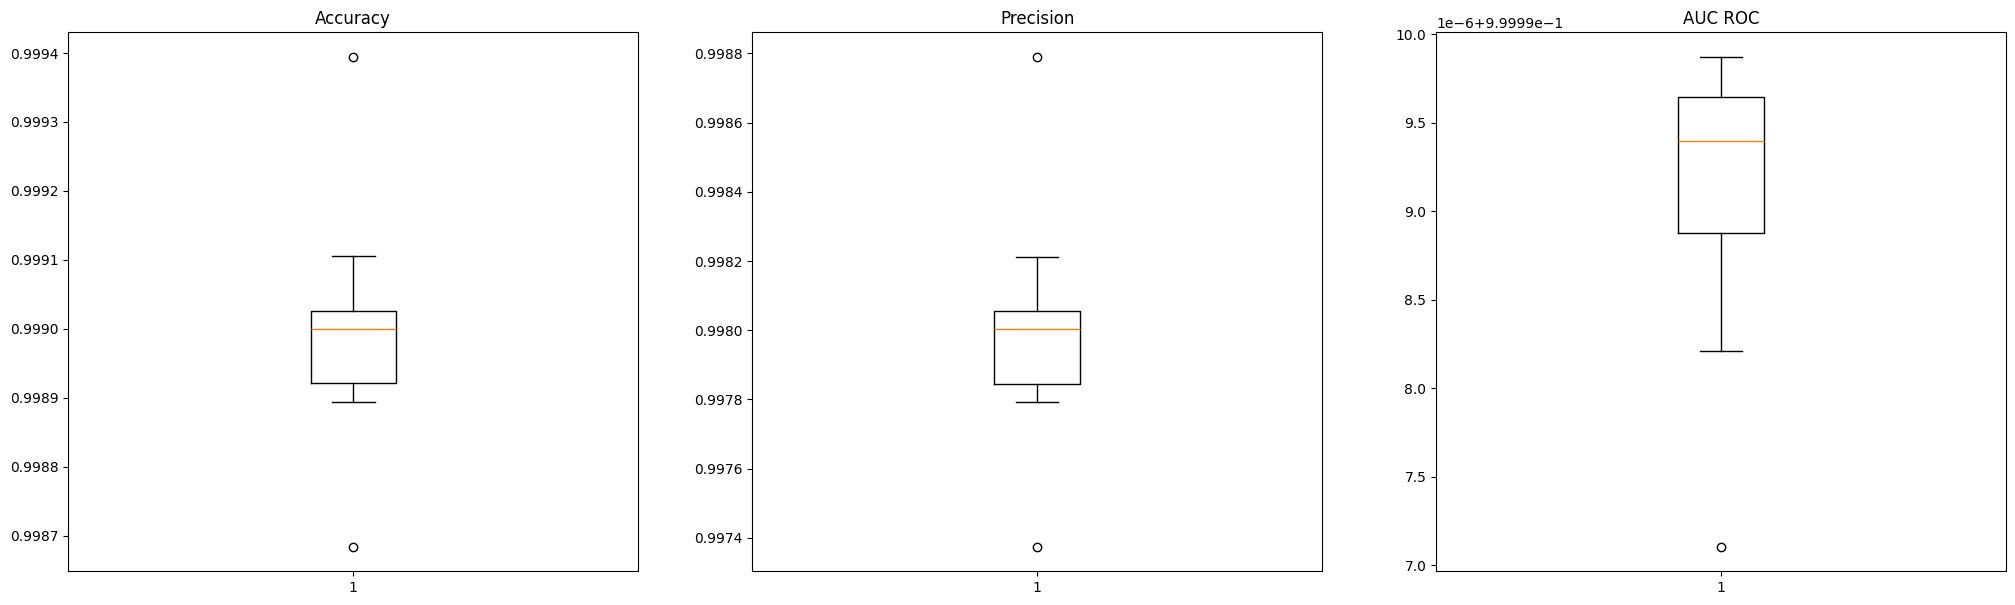

In [61]:
print(cv_scores_RF_smoth['test_accuracy'])
print(cv_scores_RF_smoth['test_precision'])
print(cv_scores_RF_smoth['test_roc_auc'])
fig = plt.figure(figsize =(25, 7))
fig.subplots_adjust(wspace=0.2, hspace=0.4)
plt.rc('axes', titlesize=12)

a1 = fig.add_subplot(1, 3, 1)
plt.boxplot(cv_scores_RF_smoth['test_accuracy'][1:])
a1.title.set_text("Accuracy")

a2 = fig.add_subplot(1, 3, 2)
plt.boxplot(cv_scores_RF_smoth['test_precision'][1:])
a2.title.set_text("Precision")

a3 = fig.add_subplot(1, 3, 3)
plt.boxplot(cv_scores_RF_smoth['test_roc_auc'][1:])
a3.title.set_text("AUC ROC")

plt.show()

In [72]:
f_statistic_RF_smoth, p_value_RF_smoth = f_oneway(*[score for score in cv_scores_RF_smoth['test_roc_auc']])

print(f"F-statistic for Random Forest on SMOTH: {f_statistic_RF_smoth}")
print(f"P-value Random Forest on SMOTH: {p_value_RF_smoth}")

F-statistic for Random Forest on SMOTH: nan
P-value Random Forest on SMOTH: nan


s:\KTH\Programing_for_data_science\.venv\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: SmallSampleWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  if is_too_small(samples, kwds):
C:\Users\zuzka\AppData\Local\Temp\ipykernel_17168\1474117263.py:1: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_statistic_RF_smoth, p_value_RF_smoth = f_oneway(*[score for score in cv_scores_RF_smoth['test_roc_auc']])


#### Decision Tree

In [73]:
print("FINAL CROSS-VALIDATION WITH DECISION TREE")
DT_smoth = DecisionTreeClassifier(max_depth=25, random_state=42)

precision_scorer = make_scorer(precision_score, zero_division=0)

#  5-fold cross-validation on the FULL training set
cv_scores_DT_smoth = cross_validate(
    DT_smoth,
    X_smoth,  # Full training set 
    y_smoth,
    cv=10,  # 5-fold cross-validation
    scoring={
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc',
        'precision': precision_scorer
    },
    n_jobs=-1,
    return_train_score=True
)

# Display cross-validation results
print(f"\nCross-Validation Results (10-fold):")
print(f"  Accuracy:  {cv_scores_DT_smoth['test_accuracy'].mean():.4f} (+/- {cv_scores_DT_smoth['test_accuracy'].std():.4f})")
print(f"  ROC-AUC:   {cv_scores_DT_smoth['test_roc_auc'].mean():.4f} (+/- {cv_scores_DT_smoth['test_roc_auc'].std():.4f})")
print(f"  Precision: {cv_scores_DT_smoth['test_precision'].mean():.4f} (+/- {cv_scores_DT_smoth['test_precision'].std():.4f})")

FINAL CROSS-VALIDATION WITH DECISION TREE

Cross-Validation Results (10-fold):
  Accuracy:  0.9307 (+/- 0.0827)
  ROC-AUC:   0.9355 (+/- 0.0833)
  Precision: 0.9347 (+/- 0.0152)


[0.68250625 0.95558773 0.95869422 0.95843096 0.96011584 0.95850994
 0.95658813 0.95643017 0.96095725 0.95911436]
[0.9800554  0.93092285 0.92781024 0.93009929 0.92998426 0.92665719
 0.93097108 0.93009526 0.9313624  0.92925713]
[0.6855633  0.96333888 0.96246478 0.96391587 0.96364416 0.96172202
 0.96344369 0.96343214 0.96436479 0.96271296]


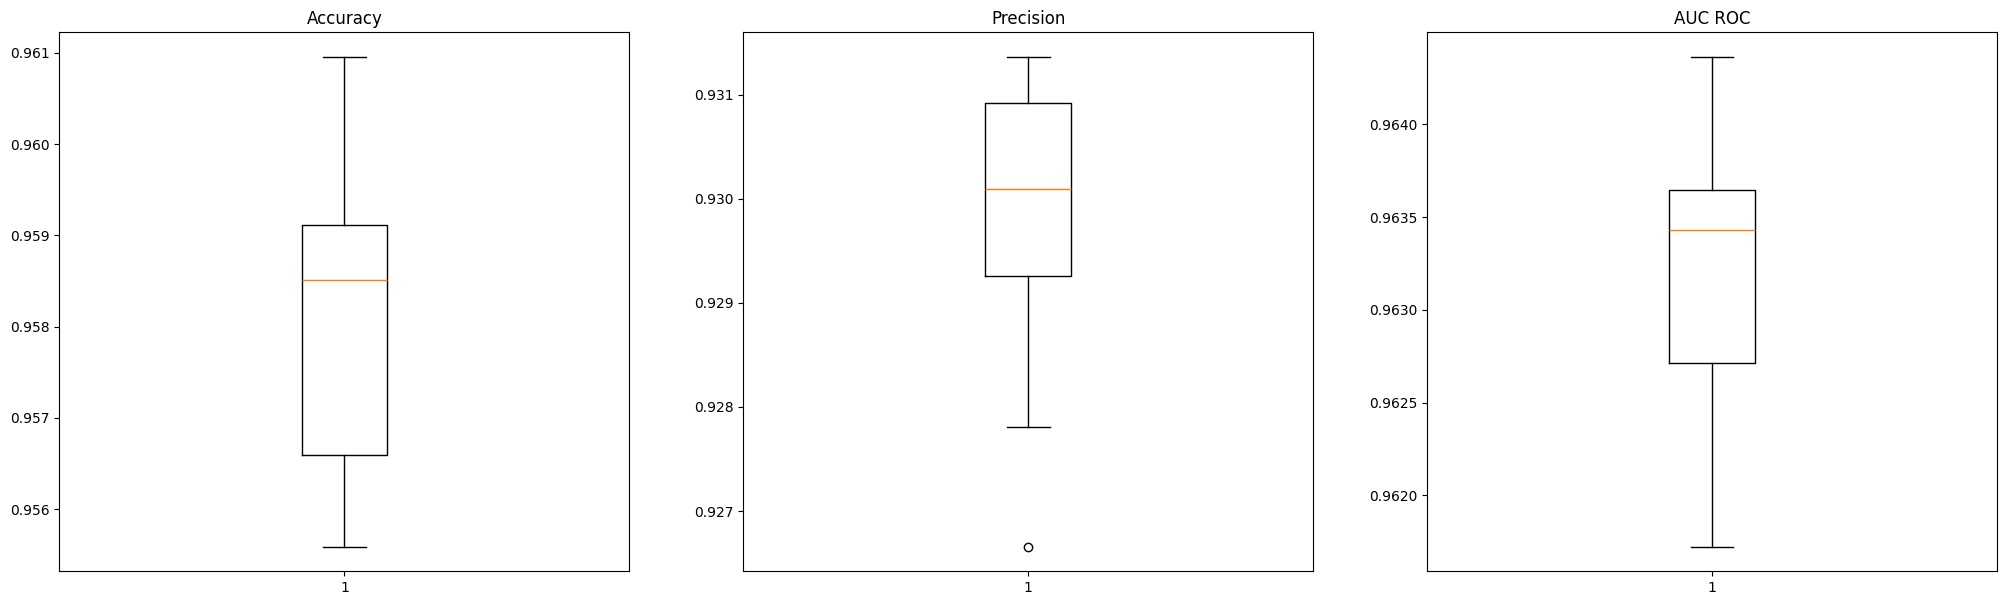

In [74]:
print(cv_scores_DT_smoth['test_accuracy'])
print(cv_scores_DT_smoth['test_precision'])
print(cv_scores_DT_smoth['test_roc_auc'])
fig = plt.figure(figsize =(25, 7))
fig.subplots_adjust(wspace=0.2, hspace=0.4)
plt.rc('axes', titlesize=12)

a1 = fig.add_subplot(1, 3, 1)
plt.boxplot(cv_scores_DT_smoth['test_accuracy'][1:])
a1.title.set_text("Accuracy")

a2 = fig.add_subplot(1, 3, 2)
plt.boxplot(cv_scores_DT_smoth['test_precision'][1:])
a2.title.set_text("Precision")

a3 = fig.add_subplot(1, 3, 3)
plt.boxplot(cv_scores_DT_smoth['test_roc_auc'][1:])
a3.title.set_text("AUC ROC")

plt.show()

### ADYSYN dataset

#### Random Forest

In [76]:
print("FINAL CROSS-VALIDATION WITH RANDOM FOREST")
RF_adysyn = RandomForestClassifier(n_estimators=250, random_state=42)

precision_scorer = make_scorer(precision_score, zero_division=0)

#  5-fold cross-validation on the FULL training set
cv_scores_RF_adysyn = cross_validate(
    RF_adysyn,
    X_adysyn,  # Full training set 
    y_adysyn,
    cv=10,  # 10-fold cross-validation
    scoring={
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc',
        'precision': precision_scorer
    },
    n_jobs=-1,
    return_train_score=True
)

# Display cross-validation results
print(f"\nCross-Validation Results (10-fold):")
print(f"  Accuracy:  {cv_scores_RF_adysyn['test_accuracy'].mean():.4f} (+/- {cv_scores_RF_adysyn['test_accuracy'].std():.4f})")
print(f"  ROC-AUC:   {cv_scores_RF_adysyn['test_roc_auc'].mean():.4f} (+/- {cv_scores_RF_adysyn['test_roc_auc'].std():.4f})")
print(f"  Precision: {cv_scores_RF_adysyn['test_precision'].mean():.4f} (+/- {cv_scores_RF_adysyn['test_precision'].std():.4f})")

FINAL CROSS-VALIDATION WITH RANDOM FOREST

Cross-Validation Results (10-fold):
  Accuracy:  nan (+/- nan)
  ROC-AUC:   nan (+/- nan)
  Precision: nan (+/- nan)


s:\KTH\Programing_for_data_science\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
6 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "s:\KTH\Programing_for_data_science\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "s:\KTH\Programing_for_data_science\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "s:\KTH\Programing_for_data_science\.venv\Lib\site-packages\sklear

In [ ]:
print(cv_scores_RF_adysyn['test_accuracy'])
print(cv_scores_RF_adysyn['test_precision'])
print(cv_scores_RF_adysyn['test_roc_auc'])
fig = plt.figure(figsize =(25, 7))
fig.subplots_adjust(wspace=0.2, hspace=0.4)
plt.rc('axes', titlesize=12)

a1 = fig.add_subplot(1, 3, 1)
plt.boxplot(cv_scores_RF_adysyn['test_accuracy'][1:])
a1.title.set_text("Accuracy")

a2 = fig.add_subplot(1, 3, 2)
plt.boxplot(cv_scores_RF_adysyn['test_precision'][1:])
a2.title.set_text("Precision")

a3 = fig.add_subplot(1, 3, 3)
plt.boxplot(cv_scores_RF_adysyn['test_roc_auc'][1:])
a3.title.set_text("AUC ROC")

plt.show()

#### Decision Tree

In [75]:
print("FINAL CROSS-VALIDATION WITH DECISION TREE")
DT_adysyn = DecisionTreeClassifier(max_depth=25, random_state=42)

precision_scorer = make_scorer(precision_score, zero_division=0)

#  5-fold cross-validation on the FULL training set
cv_scores_DT_adysyn = cross_validate(
    DT_adysyn,
    X_adysyn,  # Full training set 
    y_adysyn,
    cv=10,  # 5-fold cross-validation
    scoring={
        'accuracy': 'accuracy',
        'roc_auc': 'roc_auc',
        'precision': precision_scorer
    },
    n_jobs=-1,
    return_train_score=True
)

# Display cross-validation results
print(f"\nCross-Validation Results (10-fold):")
print(f"  Accuracy:  {cv_scores_DT_adysyn['test_accuracy'].mean():.4f} (+/- {cv_scores_DT_adysyn['test_accuracy'].std():.4f})")
print(f"  ROC-AUC:   {cv_scores_DT_adysyn['test_roc_auc'].mean():.4f} (+/- {cv_scores_DT_adysyn['test_roc_auc'].std():.4f})")
print(f"  Precision: {cv_scores_DT_adysyn['test_precision'].mean():.4f} (+/- {cv_scores_DT_adysyn['test_precision'].std():.4f})")

FINAL CROSS-VALIDATION WITH DECISION TREE

Cross-Validation Results (10-fold):
  Accuracy:  0.9282 (+/- 0.0836)
  ROC-AUC:   0.9338 (+/- 0.0852)
  Precision: 0.9343 (+/- 0.0159)


[0.67749782 0.95386405 0.9567459  0.95537107 0.95634931 0.95597917
 0.95534463 0.95481585 0.95819893 0.95822537]
[0.98183668 0.92667699 0.92882083 0.9273108  0.92958592 0.93061409
 0.92603639 0.92907979 0.93072966 0.93263443]
[0.67814386 0.96076483 0.96305254 0.9614301  0.96232995 0.96252155
 0.96045579 0.96194529 0.96287321 0.96460005]


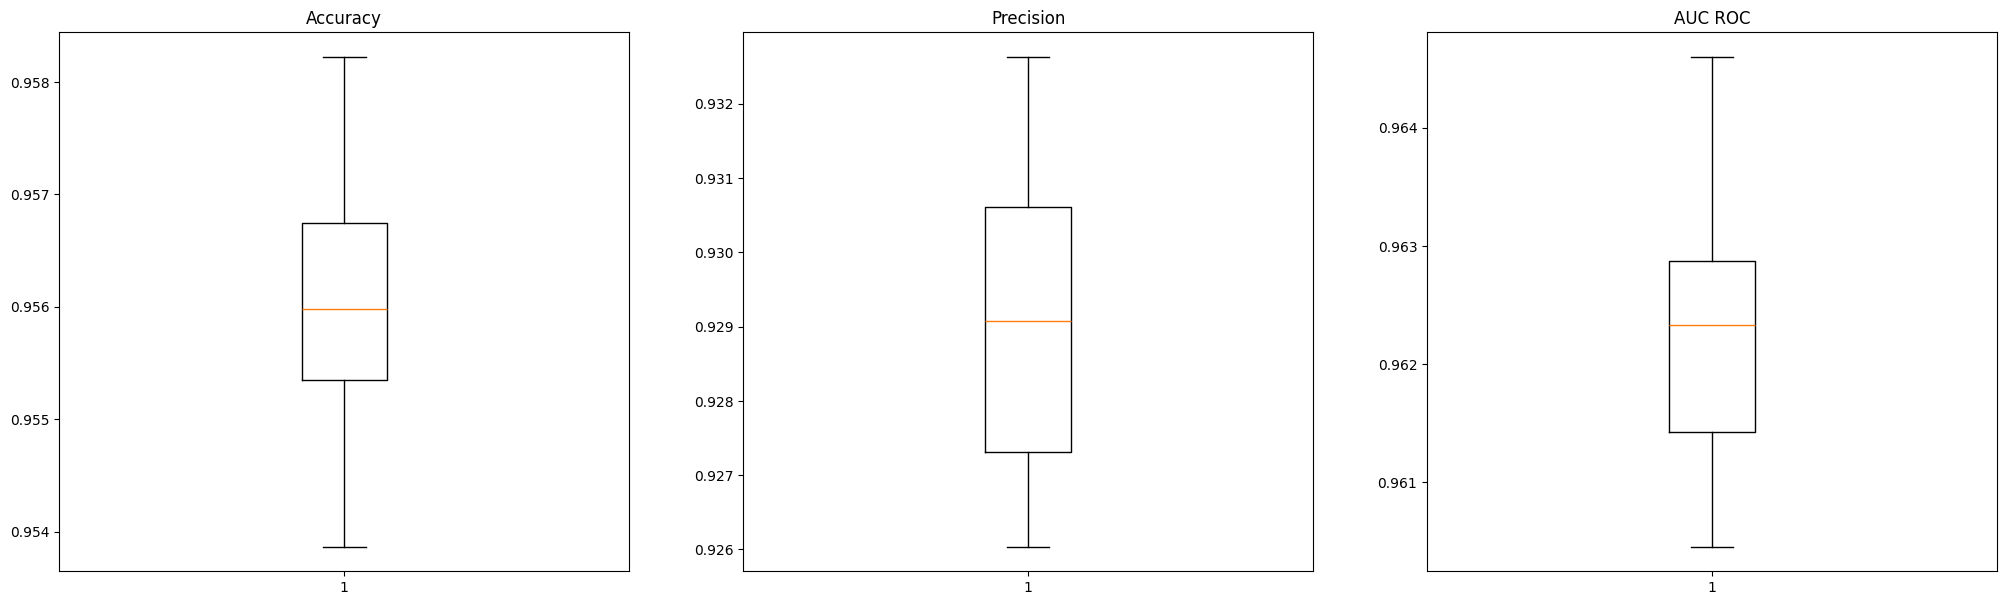

In [69]:
print(cv_scores_DT_adysyn['test_accuracy'])
print(cv_scores_DT_adysyn['test_precision'])
print(cv_scores_DT_adysyn['test_roc_auc'])
fig = plt.figure(figsize =(25, 7))
fig.subplots_adjust(wspace=0.2, hspace=0.4)
plt.rc('axes', titlesize=12)

a1 = fig.add_subplot(1, 3, 1)
plt.boxplot(cv_scores_DT_adysyn['test_accuracy'][1:])
a1.title.set_text("Accuracy")

a2 = fig.add_subplot(1, 3, 2)
plt.boxplot(cv_scores_DT_adysyn['test_precision'][1:])
a2.title.set_text("Precision")

a3 = fig.add_subplot(1, 3, 3)
plt.boxplot(cv_scores_DT_adysyn['test_roc_auc'][1:])
a3.title.set_text("AUC ROC")

plt.show()